# Feature selection
  * Sequential backward selection
  * L1 Regularization
  * Feature selection based on RF feature importance 

In [1]:
import pandas as pd

train_df = pd.read_csv('Urban land cover/training.csv')
test_df = pd.read_csv('Urban land cover/testing.csv')
combined_df = pd.concat([train_df, test_df])
combined_df

,class,BrdIndx,Area,Round,Bright,Compact,ShpIndx,Mean_G,Mean_R,Mean_NIR,...,SD_NIR_140,LW_140,GLCM1_140,Rect_140,GLCM2_140,Dens_140,Assym_140,NDVI_140,BordLngth_140,GLCM3_140
0,car,1.27,91,0.97,231.38,1.39,1.47,207.92,241.74,244.48,...,26.18,2.00,0.50,0.85,6.29,1.67,0.70,-0.08,56,3806.36
1,concrete,2.36,241,1.56,216.15,2.46,2.51,187.85,229.39,231.20,...,22.29,2.25,0.79,0.55,8.42,1.38,0.81,-0.09,1746,1450.14
2,concrete,2.12,266,1.47,232.18,2.07,2.21,206.54,244.22,245.79,...,15.59,2.19,0.76,0.74,7.24,1.68,0.81,-0.07,566,1094.04
3,concrete,2.42,399,1.28,230.40,2.49,2.73,204.60,243.27,243.32,...,13.51,3.34,0.82,0.74,7.44,1.36,0.92,-0.09,1178,1125.38
4,concrete,2.15,944,1.73,193.18,2.28,4.10,165.98,205.55,208.00,...,15.65,50.08,0.85,0.49,8.15,0.23,1.00,-0.08,6232,1146.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,building,1.36,3146,0.90,244.97,1.44,1.39,229.86,252.47,252.58,...,7.58,1.51,0.63,0.84,6.85,1.96,0.47,-0.04,784,1911.96
503,grass,2.51,428,1.55,166.02,2.16,2.61,210.11,135.89,152.04,...,18.91,1.14,0.86,0.67,7.70,1.80,0.50,0.22,1020,801.65
504,concrete,2.45,659,1.38,219.30,1.68,2.53,189.64,233.14,235.12,...,14.67,2.21,0.74,0.78,7.47,1.70,0.74,-0.09,2596,1243.03
505,building,1.90,89,1.01,219.88,2.02,2.01,184.82,235.18,239.65,...,37.11,5.26,0.75,0.85,8.47,1.30,0.94,-0.12,726,1470.63


In [2]:
# Number of examples
print(len(train_df), 'train instances')
print(len(test_df), 'test instances')

168 train instances
507 test instances


## Why do we need feature selection?
* Main reason: Curse of dimensionality
* Also makes for a smaller and simpler model!

In [3]:
# One column ("class") is not a feature; all others are
features = [f for f in train_df.columns if f != 'class']
print(len(features), 'features')

# There are way too many features in the dataset, especially for KNN or a linear model

147 features


In [4]:
# Computing the correlation matrix for features
corr = train_df[features].corr().stack().reset_index()
corr.columns = ['feature1', 'feature2', 'r']
corr = corr[corr.feature1 != corr.feature2] # Excluding self-correlations
corr

,feature1,feature2,r
1,BrdIndx,Area,-0.085323
2,BrdIndx,Round,0.812346
3,BrdIndx,Bright,-0.130840
4,BrdIndx,Compact,0.850907
5,BrdIndx,ShpIndx,0.927880
...,...,...,...
21603,GLCM3_140,GLCM2_140,-0.606967
21604,GLCM3_140,Dens_140,0.016892
21605,GLCM3_140,Assym_140,0.067005
21606,GLCM3_140,NDVI_140,-0.385285


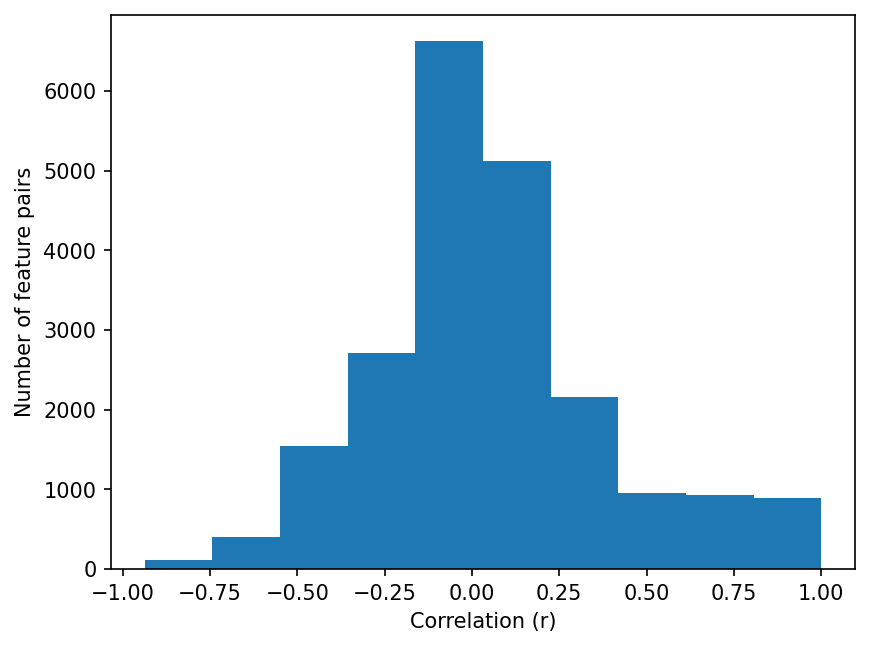

In [5]:
# Plot the correlations
import matplotlib.pyplot as plt

plt.figure(dpi=150)
plt.xlabel('Correlation (r)')
plt.ylabel('Number of feature pairs')
_ = plt.hist(corr.r)

# Lots of features are pretty correlated with each other
# There are thousands of pairs with high positive correlations (close to 1.0). 

In [6]:
# Now let's look at the maximum correlation between every feature and every other feature
abs_corr = corr.copy()
# # ignore whether correlation is positive or negative and focusing solely on strength of correlation
abs_corr['r'] = abs_corr.r.abs() 
# find maximum absolute correlation for each feature
max_corr = abs_corr.groupby('feature1').r.max()
with pd.option_context('display.max_rows', None):
    print(max_corr)

feature1
Area             0.722073
Area_100         0.867415
Area_120         1.000000
Area_140         1.000000
Area_40          0.780330
Area_60          0.820073
Area_80          0.865590
Assym            0.652553
Assym_100        0.879465
Assym_120        1.000000
Assym_140        1.000000
Assym_40         0.783763
Assym_60         0.840026
Assym_80         0.840026
BordLngth        0.722073
BordLngth_100    0.859759
BordLngth_120    1.000000
BordLngth_140    1.000000
BordLngth_40     0.780330
BordLngth_60     0.820073
BordLngth_80     0.855495
BrdIndx          0.927880
BrdIndx_100      0.878034
BrdIndx_120      1.000000
BrdIndx_140      1.000000
BrdIndx_40       0.905460
BrdIndx_60       0.926575
BrdIndx_80       0.885633
Bright           0.985570
Bright_100       0.986813
Bright_120       1.000000
Bright_140       1.000000
Bright_40        0.993430
Bright_60        0.993430
Bright_80        0.986813
Compact          0.886718
Compact_100      0.936071
Compact_120      1.000000
Com

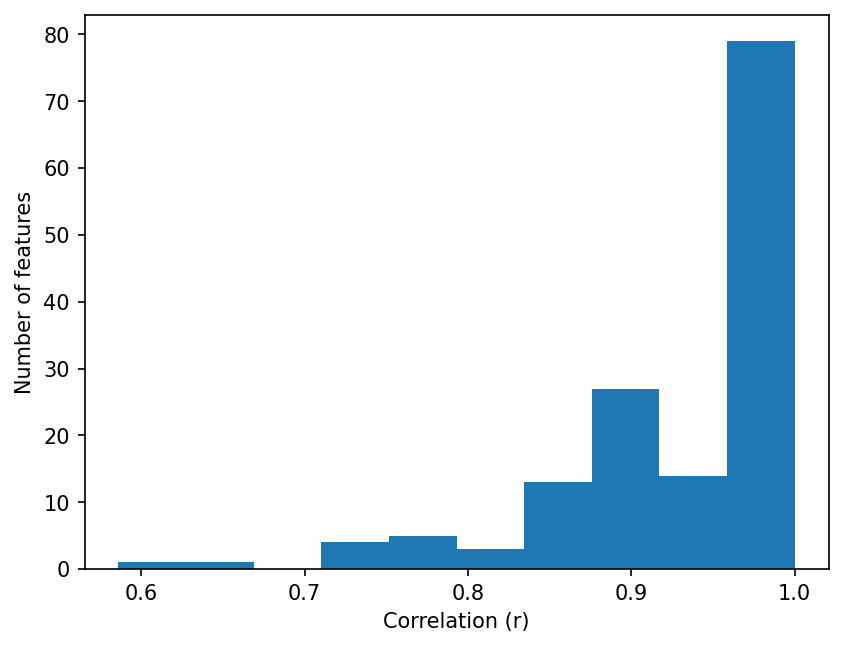

In [7]:
plt.figure(dpi=150)
plt.xlabel('Correlation (r)')
plt.ylabel('Number of features')
_ = plt.hist(max_corr)
# Each feature has at least one other feature that it is very highly correlated with
# So, we should remove some of these!

## Sequential backward selection
### Manually first

In [8]:
# Run through *one* iteration manually, i.e., removing one feature
from sklearn import neighbors, metrics, model_selection

model = neighbors.KNeighborsClassifier(5)
xval = model_selection.KFold(2, shuffle=True) # 2-fold for spee
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(model, train_df[features], train_df['class'], cv=xval, scoring=scorer)
print('Kappa:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())

best_kappa = -1
best_i = None
for i in range(len(features)):
    subset_features = features[:i] + features[i + 1:] #skip i-th feature
    new_result = model_selection.cross_validate(model, train_df[subset_features], train_df['class'], cv=xval, scoring=scorer)
    test_kappa = new_result['test_score'].mean()
    if test_kappa > best_kappa:
        best_kappa = test_kappa
        best_i = i
print('Best kappa:', best_kappa)
print('Best feature to remove:', features[best_i])

Kappa: 0.26878371059245776
Kappa SD: 0.021664632487464197
Best kappa: 0.38597078885334307
Best feature to remove: Mean_G_60


### Scikit-learn implementation

In [9]:
print('before:', train_df[features].shape)

before: (168, 147)


In [ ]:
from sklearn import feature_selection
model = neighbors.KNeighborsClassifier(5)
xval = model_selection.KFold(2, shuffle=True) # 2-fold for speed
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

fs = feature_selection.SequentialFeatureSelector(
    model, direction='backward',
    n_features_to_select=100,
    scoring=scorer,
    cv=xval)

fs.fit(train_df[features], train_df['class'])

SequentialFeatureSelector(cv=KFold(n_splits=2, random_state=None, shuffle=True),
                          direction='backward',
                          estimator=KNeighborsClassifier(),
                          n_features_to_select=100,
                          scoring=make_scorer(cohen_kappa_score, response_method='predict'))

In [11]:
train_X = fs.transform(train_df[features])
print('after:', train_X.shape)

after: (168, 100)


In [12]:
test_X = fs.transform(test_df[features])
test_X.shape

(507, 100)

In [13]:
# Model performance after FS
model.fit(train_X, train_df['class'])
preds = model.predict(test_X)
print('FS kappa:', metrics.cohen_kappa_score(test_df['class'], preds))

# Versus without FS
model.fit(train_df[features], train_df['class'])
preds = model.predict(test_df[features])
print('No FS kappa:', metrics.cohen_kappa_score(test_df['class'], preds))

FS kappa: 0.3349673641516022
No FS kappa: 0.28426972880086954


In [14]:
# Now let's try FS in a pipeline
# 145 features as this is a bit slow
from sklearn import pipeline

pipe = pipeline.Pipeline([
    ('fs', feature_selection.SequentialFeatureSelector(model, n_features_to_select=145,
        direction='backward', scoring=scorer, cv=xval)),
    ('model', model)
])

result = model_selection.cross_validate(pipe, combined_df[features], combined_df['class'], cv=xval, scoring=scorer)
print('Kappa:', result['test_score'].mean())

Kappa: 0.3370904855394925


## RF feature importance

### Importance as Gini impurity decrease

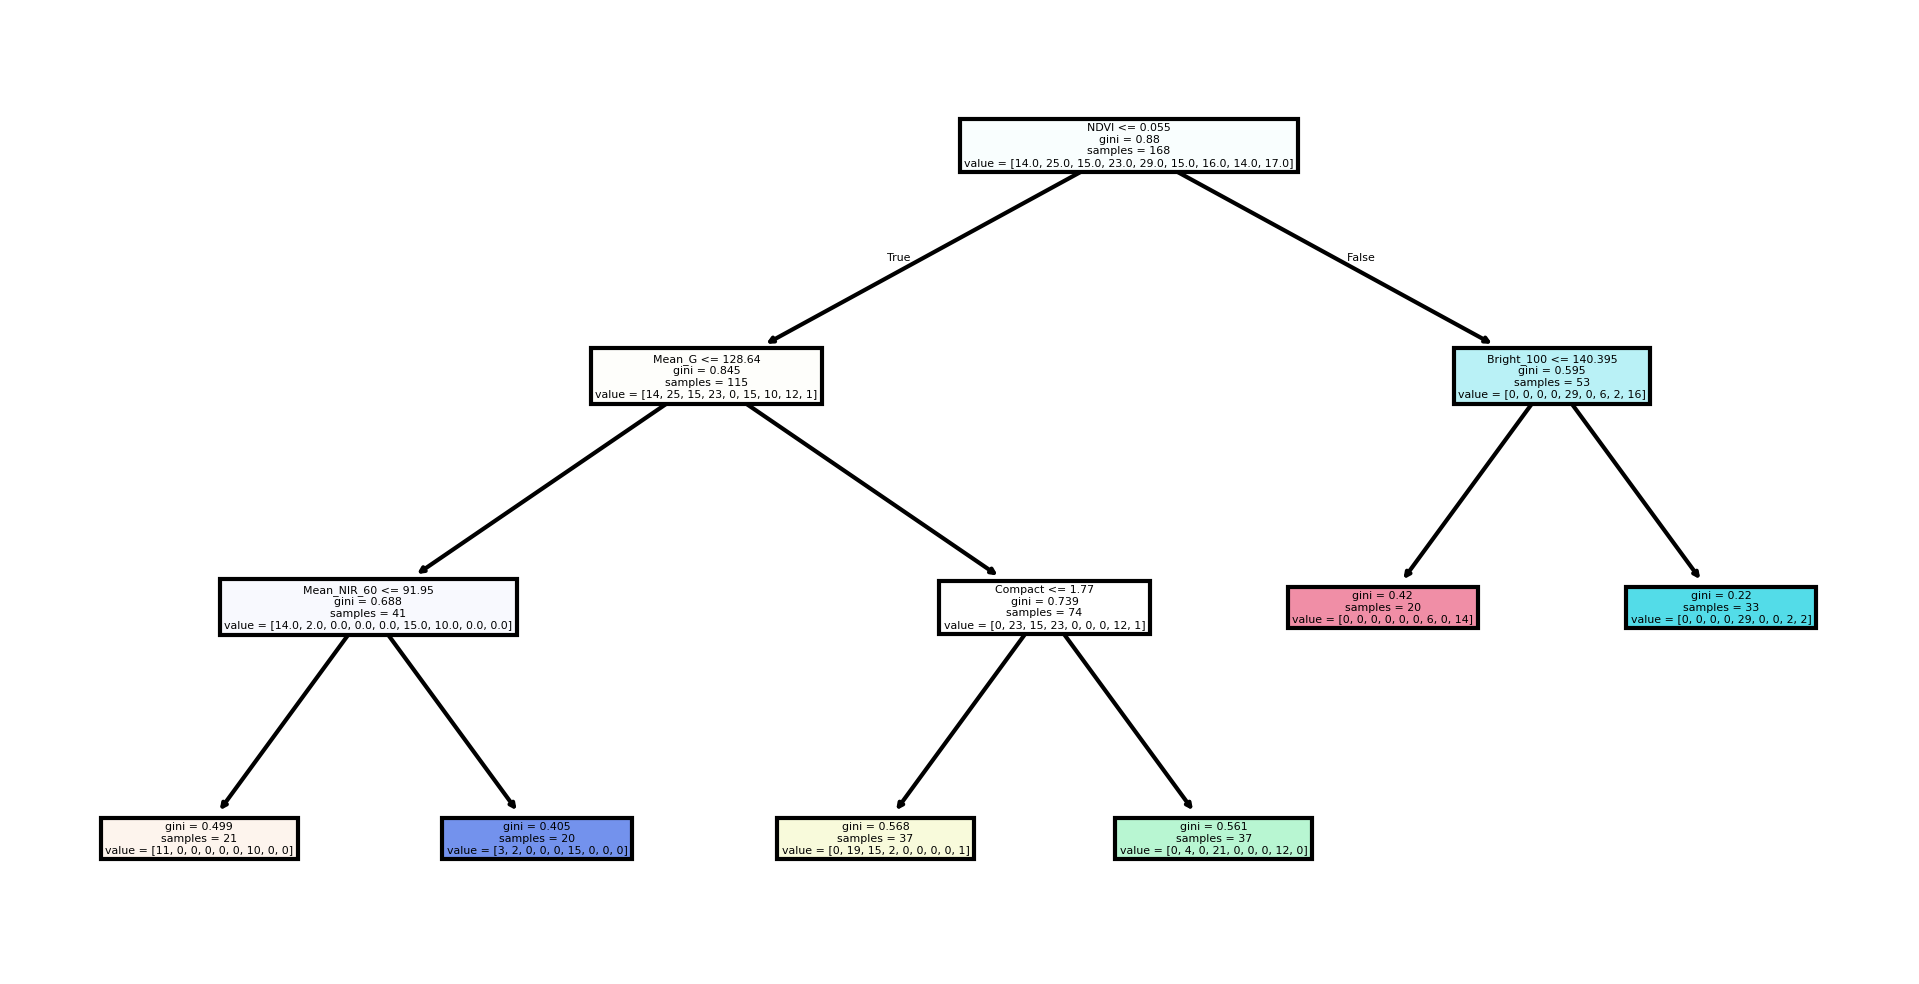

In [15]:
# Plot single tree
from sklearn import tree

model = tree.DecisionTreeClassifier(min_samples_leaf=20)
model.fit(train_df[features], train_df['class'])
plt.figure(dpi=300, figsize=(8, 4))
_ = tree.plot_tree(model, feature_names=features, filled=True)
# filled=True DT plot with different colors representing different predicted classes at each node. 
# Each color corresponds to a unique class and color intensity is based on the purity of the node. 

### Importance for a Random Forest

In [16]:
# Plot importances for a whole forest
from sklearn import ensemble

model = ensemble.RandomForestClassifier(max_depth=5)
model.fit(train_df[features], train_df['class'])
model.feature_importances_

array([0.00660619, 0.00638304, 0.00014938, 0.01723256, 0.00869194,
       0.00248904, 0.01758187, 0.02087462, 0.01443512, 0.0091133 ,
       0.00730498, 0.00633392, 0.00103021, 0.00205379, 0.00199817,
       0.00136394, 0.00043218, 0.00131513, 0.03666043, 0.01224439,
       0.00227467, 0.00683921, 0.01666663, 0.00085833, 0.01997175,
       0.00179273, 0.002417  , 0.0096928 , 0.01988096, 0.01467396,
       0.00348319, 0.00184966, 0.00128958, 0.00128882, 0.00279346,
       0.0007022 , 0.00079239, 0.00216534, 0.00070023, 0.03038836,
       0.00551383, 0.00529523, 0.00690671, 0.01851142, 0.00096671,
       0.01101904, 0.00284098, 0.00680634, 0.01977599, 0.01750661,
       0.0210924 , 0.00557233, 0.00139007, 0.00221924, 0.        ,
       0.0038272 , 0.00013422, 0.00236823, 0.00089245, 0.00052278,
       0.0447518 , 0.01709509, 0.00259887, 0.00680843, 0.00742608,
       0.00302517, 0.02701881, 0.00310746, 0.00446724, 0.00975107,
       0.0165014 , 0.01898664, 0.01059513, 0.00332274, 0.00437

In [17]:
model.feature_importances_.sum() # Feature importances sum to 1

1.0

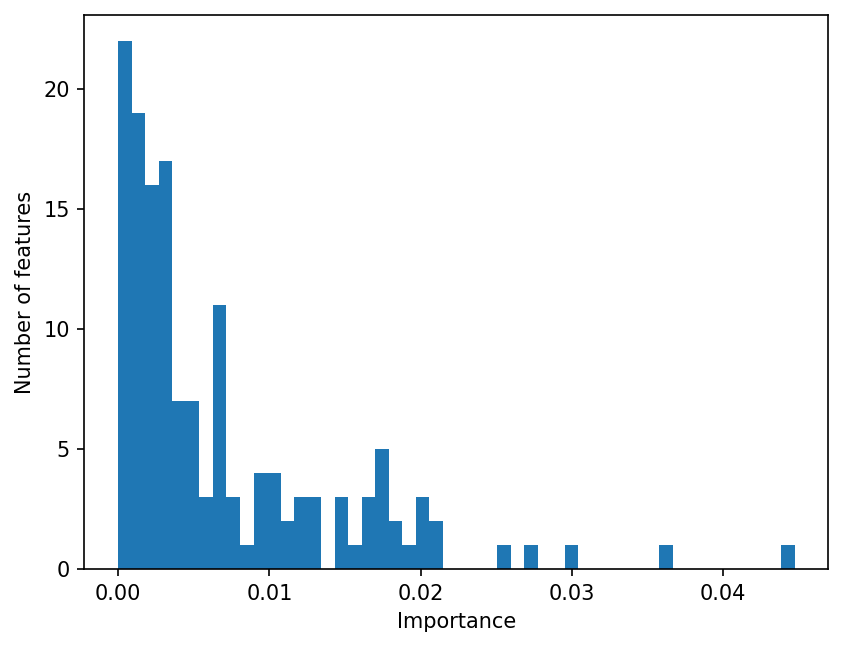

In [18]:
plt.figure(dpi=150)
plt.xlabel('Importance')
plt.ylabel('Number of features')
_ = plt.hist(model.feature_importances_, bins=50)

Save as a DataFrame, useful for interpretation (including in class projects).

In [19]:
feat_df = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feat_df.sort_values('importance', ascending=False)

,feature,importance
60,NDVI_60,0.044752
18,NDVI,0.036660
39,NDVI_40,0.030388
66,Bright_80,0.027019
81,NDVI_80,0.025306
...,...,...
2,Round,0.000149
56,Rect_60,0.000134
98,Rect_100,0.000132
139,GLCM1_140,0.000127


In [20]:
feat_df.importance.describe()
good_features = feat_df[feat_df.importance > 0.003335]
good_features.feature

0           BrdIndx
1              Area
3            Bright
4           Compact
6            Mean_G
           ...     
132      Mean_G_140
133      Mean_R_140
134    Mean_NIR_140
137      SD_NIR_140
144        NDVI_140
Name: feature, Length: 75, dtype: object

### Feature importance for selection

In [21]:
#SelectFromModel: Meta-transformer for selecting features based on importance weights.
# https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectFromModel.html
fs = feature_selection.SelectFromModel(
    ensemble.RandomForestClassifier(max_depth=5),
    threshold='median') 
# Features whose absolute importance value is greater or equal than the (median) threshold are kept while the others are discarded. 

fs.fit(train_df[features], train_df['class'])
train_X = fs.transform(train_df[features])
print('train shape', train_X.shape)

test_X = fs.transform(test_df[features])
print('test shape', test_X.shape)

model = neighbors.KNeighborsClassifier(5)
model.fit(train_X, train_df['class'])
preds = model.predict(test_X)
print('Kappa FS:', metrics.cohen_kappa_score(test_df['class'], preds))

# Versus original:
model.fit(train_df[features], train_df['class'])
preds = model.predict(test_df[features])
print('Kappa no FS:', metrics.cohen_kappa_score(test_df['class'], preds))

train shape (168, 74)
test shape (507, 74)
Kappa FS: 0.27764875077044016
Kappa no FS: 0.28426972880086954


### Using a pipeline

In [22]:
from sklearn import pipeline, preprocessing

pipe = pipeline.Pipeline([
    ('fs', feature_selection.SelectFromModel(
        ensemble.RandomForestClassifier(min_samples_leaf=5),
        threshold='median')),
    ('scaling', preprocessing.StandardScaler()),
    ('model', neighbors.KNeighborsClassifier(5)),
])
xval = model_selection.KFold(10, shuffle=True)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)
result = model_selection.cross_validate(pipe,
    combined_df[features], combined_df['class'],
    cv=xval, scoring=scorer,
    return_train_score=True, return_estimator=True)

print('Kappa mean:', result['test_score'].mean())
print('Kappa SD:', result['test_score'].std())
print('Train kappa mean:', result['train_score'].mean())

Kappa mean: 0.7667747938292575
Kappa SD: 0.0512853146597986
Train kappa mean: 0.8594085230386372


## L1 feature selection

In [23]:
from sklearn import linear_model

# NOTE: C here is **inverse** of regularization strength. Smaller values specify stronger regularization.
model = linear_model.LogisticRegression('l1', solver='liblinear', C=.1)
model.fit(train_df[features], train_df['class'])
# Row dimension is one set of coefficients per class
coef = pd.DataFrame(model.coef_)
coef

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,0.0,-0.014957,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000668,0.001193
1,0.0,0.005243,0.0,0.000000,0.0,0.0,-0.003403,0.000000,-0.053933,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.004157,-0.003237
2,0.0,-0.035714,0.0,0.000000,0.0,0.0,0.013242,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000026
3,0.0,-0.000674,0.0,0.000000,0.0,0.0,-0.076987,0.061152,0.000000,0.0,...,0.0,0.089982,0.0,0.0,0.0,0.0,0.0,0.0,-0.000299,-0.001104
4,0.0,-0.000460,0.0,-0.045232,0.0,0.0,-0.052452,0.000000,-0.126580,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000804,-0.000736
5,0.0,-0.002381,0.0,0.000000,0.0,0.0,-0.035797,0.000000,0.033788,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000290
6,0.0,0.000000,0.0,0.000000,0.0,0.0,-0.017171,-0.151764,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.005144,0.001103
7,0.0,-0.022221,0.0,0.000000,0.0,0.0,0.013890,0.024129,0.000000,0.0,...,0.0,-0.028264,0.0,0.0,0.0,0.0,0.0,0.0,-0.001087,0.000987
8,0.0,-0.028941,0.0,0.000000,0.0,0.0,0.103184,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.004036,-0.004253


In [24]:
feature_coeffs = pd.DataFrame({'feature': features, 'coef': coef.iloc[0]})
feature_coeffs

,feature,coef
0,BrdIndx,0.000000
1,Area,-0.014957
2,Round,0.000000
3,Bright,0.000000
4,Compact,0.000000
...,...,...
142,Dens_140,0.000000
143,Assym_140,0.000000
144,NDVI_140,0.000000
145,BordLngth_140,0.000668


## Overfitting feature selection
* Generate a random dataset
* Select features based on testing data

In [25]:
import numpy as np
new_data = np.random.random([200, 1000])
features = ['col' + str(i) for i in range(1000)]
new_df = pd.DataFrame(new_data, columns=features)
new_df['label'] = np.random.randint(0, 2, 200)

model = ensemble.RandomForestClassifier()
train_df = new_df.iloc[:100]
test_df = new_df.iloc[100:]
model.fit(new_df[features], new_df.label)  # Oops! Used whole dataset for feature selection!
feat_df = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feat_df.sort_values('importance', ascending=False)

top_features = feat_df[feat_df.importance > feat_df.importance.quantile(.95)]
new_features = top_features.feature.tolist()

# Now because of overfitting feature selection, we end up with kappa that *seems* above chance
# even though that is impossible with random data -- illustrates the dangers of overfitting
model.fit(train_df[new_features], train_df.label)
preds = model.predict(test_df[new_features])
print('Kappa:', metrics.cohen_kappa_score(test_df.label, preds))


Kappa: 0.25218113834648936
